In [8]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset, load_from_disk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import time


In [7]:
main_path = '/Users/aakashagarwal/Downloads/ir_assignment2/'

In [3]:

torch.set_num_threads(16)
torch.manual_seed(0)


In [4]:
device = 'cpu'

In [26]:
ds = load_dataset("uoft-cs/cifar10")
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [6]:
processor = AutoImageProcessor.from_pretrained("google/vit-large-patch32-384",use_fast=True)
model = AutoModelForImageClassification.from_pretrained("google/vit-large-patch32-384")

model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

In [9]:
transform = transforms.Compose([
        transforms.Resize((384, 384)),  # Resize images to a consistent size
        transforms.ToTensor(),           # Convert PIL images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def extract_features(batch):
    imgs = batch['img'] 

    # Preprocess each image in the batch
    img_tensors = [transform(img).unsqueeze(0).to('cpu') for img in imgs]  # Add batch dimension and move to device
    img_tensors = torch.cat(img_tensors, dim=0)  # Concatenate to create a batch tensor

    inputs = {'pixel_values': img_tensors}  

    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states  
    
    final_hidden_state = hidden_states[-1]  
    pooled_features = final_hidden_state.mean(dim=1)  
    
    return {"features": pooled_features.cpu().numpy()} 

output_dir = main_path+ "features/cifar10/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "vit_large/") 



In [10]:
# Check if features already exist
if os.path.exists(output_file):
    print(f"Features file already exists at {output_file}. Loading features...")
    # Load existing features
    ds_feature = load_from_disk(output_file)
else:
    print("Features file does not exist. Extracting features...")

    # Use `map` to apply the feature extraction across the entire dataset
    ds_feature = ds.map(extract_features, batched=True, batch_size=64, num_proc=16)

    # Save the dataset with the new features to disk
    ds_feature.save_to_disk(output_file)  # Saving in the Arrow format
    print("Features saved successfully!")



Features file already exists at /Users/aakashagarwal/Downloads/ir_assignment2/features/cifar10/vit_large/. Loading features...


In [27]:
from datasets import DatasetDict

dataset_dict = DatasetDict({
    'train': ds_feature['train'],  # Your original train dataset
    'test': ds_feature['test']     # Your original test dataset
})

# Add index column to the train and test datasets
def add_index(example, idx):
    example['index'] = idx
    return example

# Apply the map function to add the 'index' column
ds_feature['train'] = dataset_dict['train'].map(add_index, with_indices=True)
ds_feature['test'] = dataset_dict['test'].map(add_index, with_indices=True)

In [28]:
def custom_collate(batch):
    # Define the transformations you want to apply to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to a consistent size
        transforms.ToTensor(),           # Convert PIL images to tensors
    ])

    # Extracting each field from the batch
    index = [item['index'] for item in batch]
    images = [transform(item['img']) for item in batch]  # Load and transform images
    labels = torch.tensor([item['label'] for item in batch])          # Convert labels to a tensor
    features = [torch.tensor(item['features']) for item in batch]     # Convert features to tensors
    
    # Return a dictionary with batched data
    return {
        'index': index,
        'img': torch.stack(images),    # Stack image tensors into a single tensor
        'label': labels,
        'features': torch.stack(features),  # Stack feature tensors into a single tensor
    }


In [12]:

train_dataloader = DataLoader(ds_feature['train'], batch_size=64, shuffle=False,collate_fn=custom_collate)
test_dataloader = DataLoader(ds_feature['test'], batch_size=64, shuffle=False,collate_fn=custom_collate)

train_features = []
train_labels = []
test_features = []
test_labels = []


In [13]:
for batch in train_dataloader:
    train_features.append(batch['features'].numpy())
    train_labels.append(batch['label'].numpy())
train_features_np = np.concatenate(train_features)
train_labels_np = np.concatenate(train_labels)

for batch in test_dataloader:
    test_features.append(batch['features'].numpy())
    test_labels.append(batch['label'].numpy())
test_features_np = np.concatenate(test_features)
test_labels_np = np.concatenate(test_labels)

In [18]:
def mean_average_precision_at_k(true_labels, sorted_indices, k):
    """Calculate Mean Average Precision at k for all queries"""
    average_precisions = []
    sorted_indices = np.array(sorted_indices) 
    for i in range(len(true_labels)):
        relevant = (train_labels_np[sorted_indices[i, :k].astype(int)] == true_labels[i]).float()  # Ensure integer indexing
        precision_at_i = torch.cumsum(relevant, dim=0) / torch.arange(1, k + 1, dtype=torch.float)
        if relevant.sum() > 0:
            average_precisions.append((precision_at_i * relevant).sum() / relevant.sum())
        else:
            average_precisions.append(torch.tensor(0.0))
    return torch.mean(torch.stack(average_precisions))

def precision_at_k(true_labels, sorted_indices, k):
    """Calculate Precision at k"""
    precision_at_k = []

    for i in range(len(true_labels)):
        # Ensure sorted_indices[i, :k] is a numpy array of integers
        relevant_indices = sorted_indices[i][:k]
        relevant_indices = relevant_indices[relevant_indices != -1]  # Assuming -1 is the padding value
        
        if len(relevant_indices) > 0:
            relevant = (train_labels_np[relevant_indices.astype(int)] == true_labels[i]).float()
            precision_at_k.append(relevant.sum() / k)
        else:
            precision_at_k.append(torch.tensor(0.0))
    return torch.mean(torch.stack(precision_at_k))

k_values = [5, 7, 10, 25, 50, 100]


def cluster_based_retrieval(test_features_np, train_features_np, train_labels, test_labels_pred, train_cluster_labels, k=50):
    sorted_indices = []
    for i, test_feature in enumerate(test_features_np):
        test_cluster = test_labels_pred[i]
        
        same_cluster_indices = np.where(train_cluster_labels == test_cluster)[0]
        same_cluster_train_features = train_features_np[same_cluster_indices]
        
        distances = pairwise_distances(test_feature.reshape(1, -1), same_cluster_train_features).flatten()
        
        sorted_cluster_indices = np.argsort(distances)[:k]
        if len(sorted_cluster_indices) < k:
            sorted_indices.append(np.pad(same_cluster_indices[sorted_cluster_indices], (0, k - len(sorted_cluster_indices)), constant_values=-1))
        else:
            sorted_indices.append(same_cluster_indices[sorted_cluster_indices])
    
    return np.array(sorted_indices, dtype=object)




In [20]:
# Assuming the previous code is already present
cluster_list = []
for i in k_values:
    print(f"Evaluating for k={i} clusters")

    # Fit KMeans on training features
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(train_features_np)

    # Predict clusters for test samples
    test_labels_pred = kmeans.predict(test_features_np)
    
    # Predict cluster labels for training samples
    train_cluster_labels = kmeans.labels_

    # Create a dictionary to group test sample indices by cluster
    cluster_dict = {}
    for idx, cluster in enumerate(test_labels_pred):
        if cluster not in cluster_dict:
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(idx)

    # Now, cluster_dict contains indices of test samples in each cluster
    for cluster, indices in cluster_dict.items():
        print(f"Cluster {cluster}: Test Sample Indices: {indices}")

    start_time = time.time()
    # Sort the distances to get the nearest clusters for each test sample
    sorted_indices = cluster_based_retrieval(test_features_np, train_features_np, train_labels, test_labels_pred, train_cluster_labels)  
    end_time = time.time()
    retrieval_time = end_time - start_time

    # Convert train and test labels to tensors for metric calculation
    train_labels_tensor = torch.tensor(train_labels_np)
    test_labels_tensor = torch.tensor(test_labels_np)
    map_score = mean_average_precision_at_k(test_labels_tensor, sorted_indices, k=50)
    precision_at_10 = precision_at_k(test_labels_tensor, sorted_indices, k=10)
    precision_at_50 = precision_at_k(test_labels_tensor, sorted_indices, k=50)

    # Output the results
    print(f"For k={i} clusters:") 
    print(f"retrieval-time: {retrieval_time}")
    print(f"Mean Average Precision (mAP)@50: {map_score:.4f}")
    print(f"Precision@10: {precision_at_10:.4f}")
    print(f"Precision@50: {precision_at_50:.4f}")
    cluster_list.append(cluster_dict)


Evaluating for k=100 clusters
Cluster 18: Test Sample Indices: [0, 78, 103, 115, 245, 251, 323, 397, 399, 664, 671, 688, 932, 948, 1030, 1050, 1208, 1275, 1280, 1373, 1454, 1525, 1530, 1552, 1593, 1607, 1612, 1625, 1794, 1830, 1936, 1957, 1964, 2054, 2068, 2107, 2243, 2401, 2526, 2529, 2612, 2759, 2815, 2823, 2923, 2991, 3067, 3073, 3194, 3228, 3234, 3259, 3267, 3390, 3414, 3513, 3539, 3602, 3614, 3628, 3633, 3646, 3674, 3859, 3867, 3901, 4147, 4266, 4346, 4352, 4391, 4393, 4500, 4581, 4605, 4618, 4687, 4710, 4804, 4818, 4820, 4830, 4862, 4914, 5007, 5128, 5147, 5176, 5218, 5228, 5232, 5313, 5343, 5413, 5486, 5493, 5525, 5535, 5559, 5565, 5605, 5671, 5701, 5943, 6068, 6126, 6131, 6134, 6174, 6340, 6514, 6525, 6553, 6587, 6694, 6722, 6781, 6786, 6827, 6842, 7275, 7300, 7352, 7370, 7401, 7596, 7789, 7879, 7905, 8023, 8072, 8102, 8169, 8174, 8193, 8251, 8258, 8271, 8279, 8281, 8298, 8310, 8324, 8337, 8338, 8362, 8467, 8525, 8532, 8658, 8662, 8736, 8749, 8930, 9043, 9120, 9121, 9190, 9191,

In [30]:
for i, (key,value) in enumerate(cluster_dict.items()):
    print(ds_feature['test'][value]['label'])
    break

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 5, 3, 3, 3]


Samples from cluster:  36


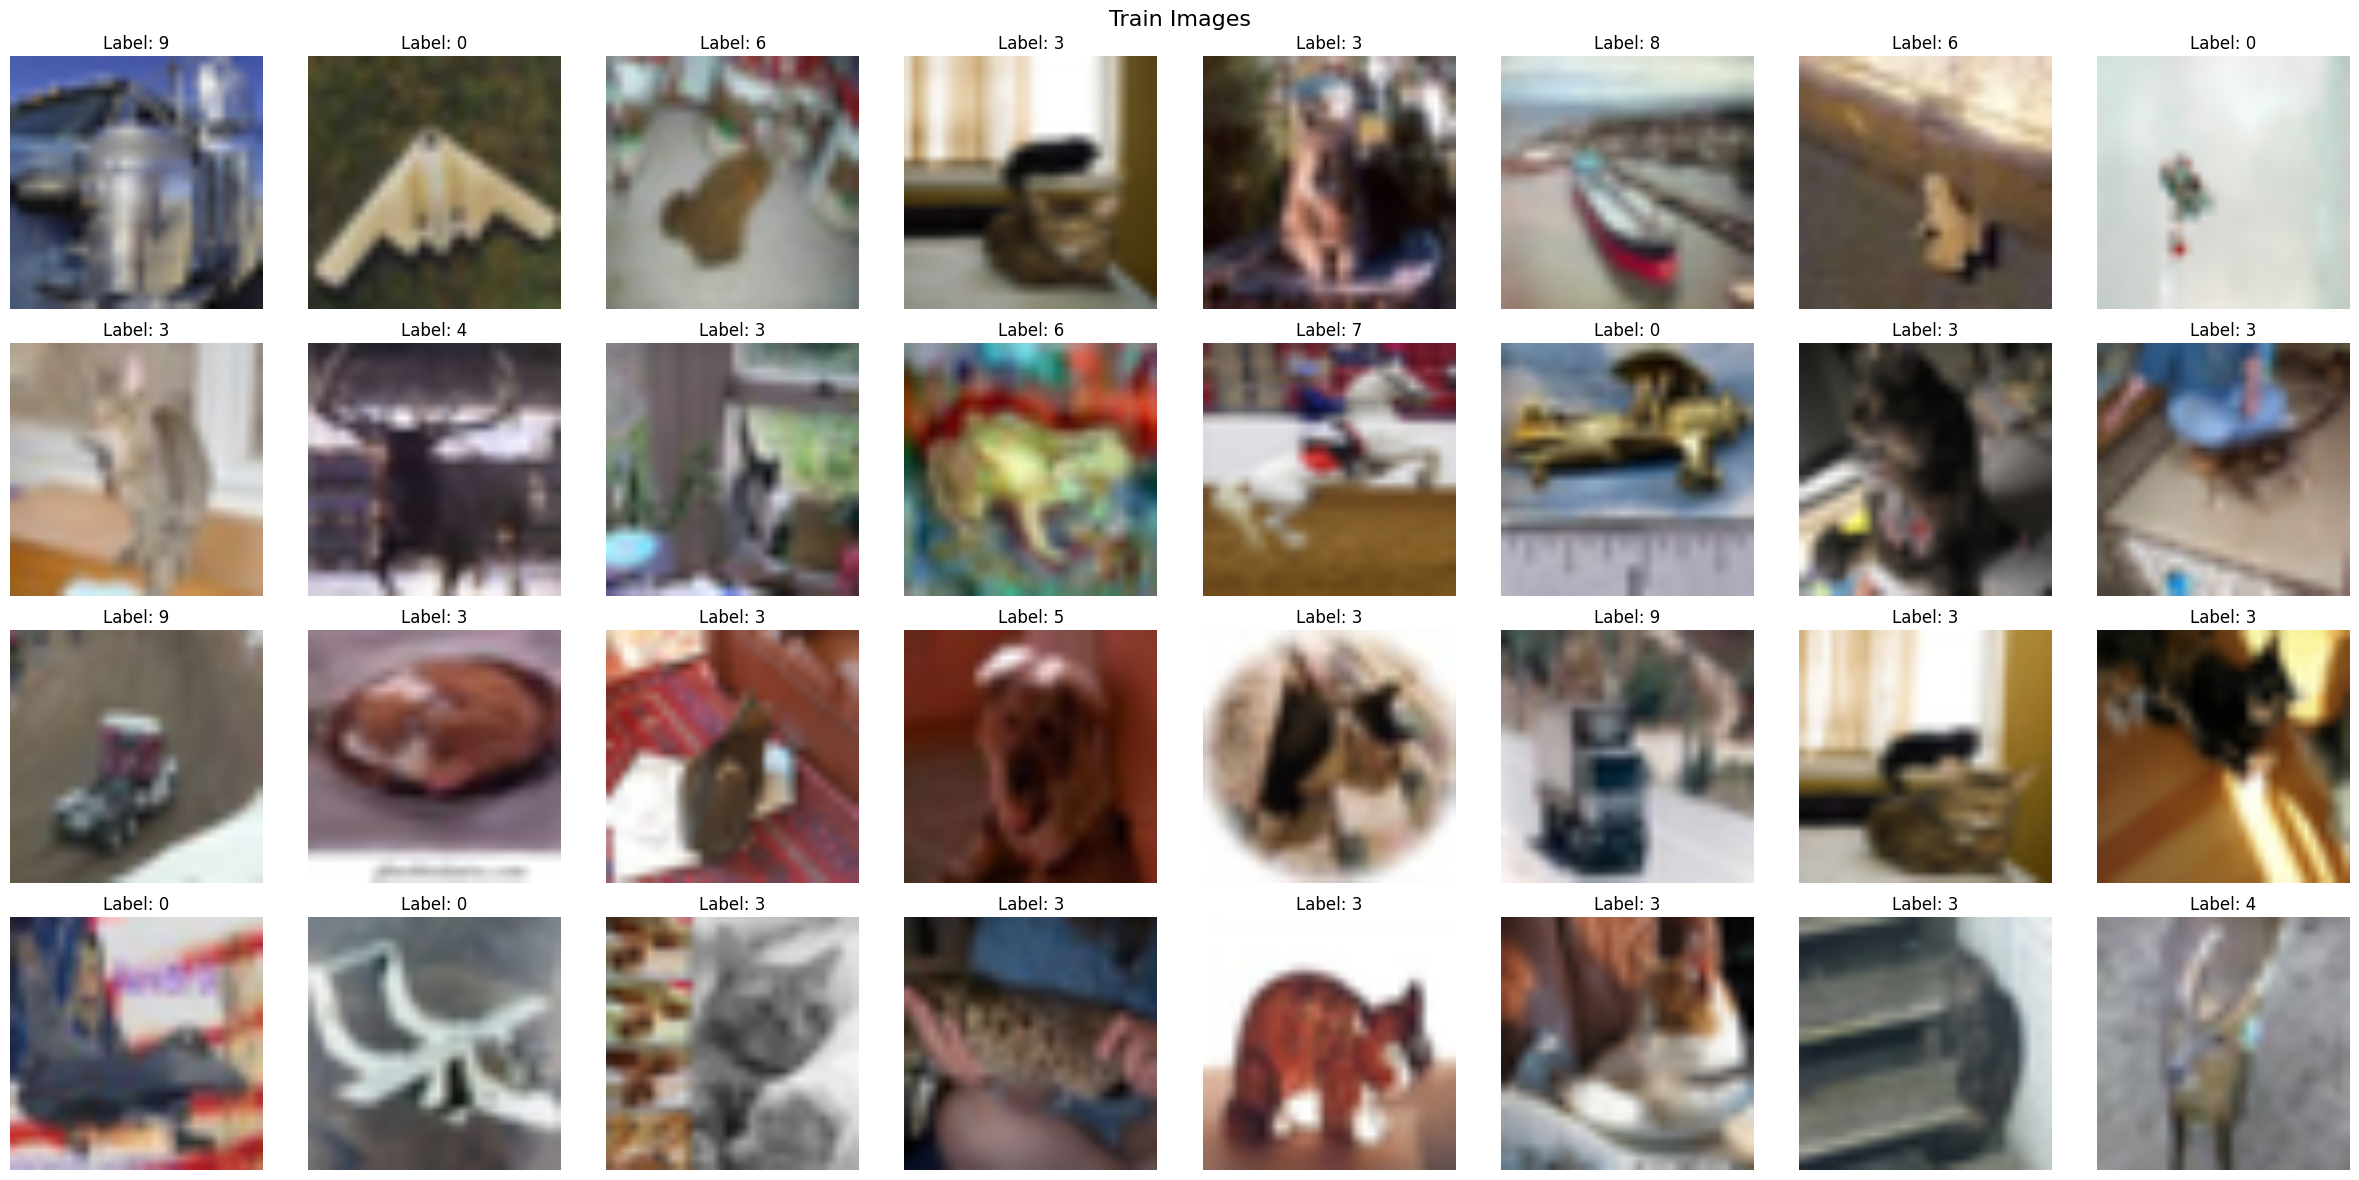

Samples from cluster:  72


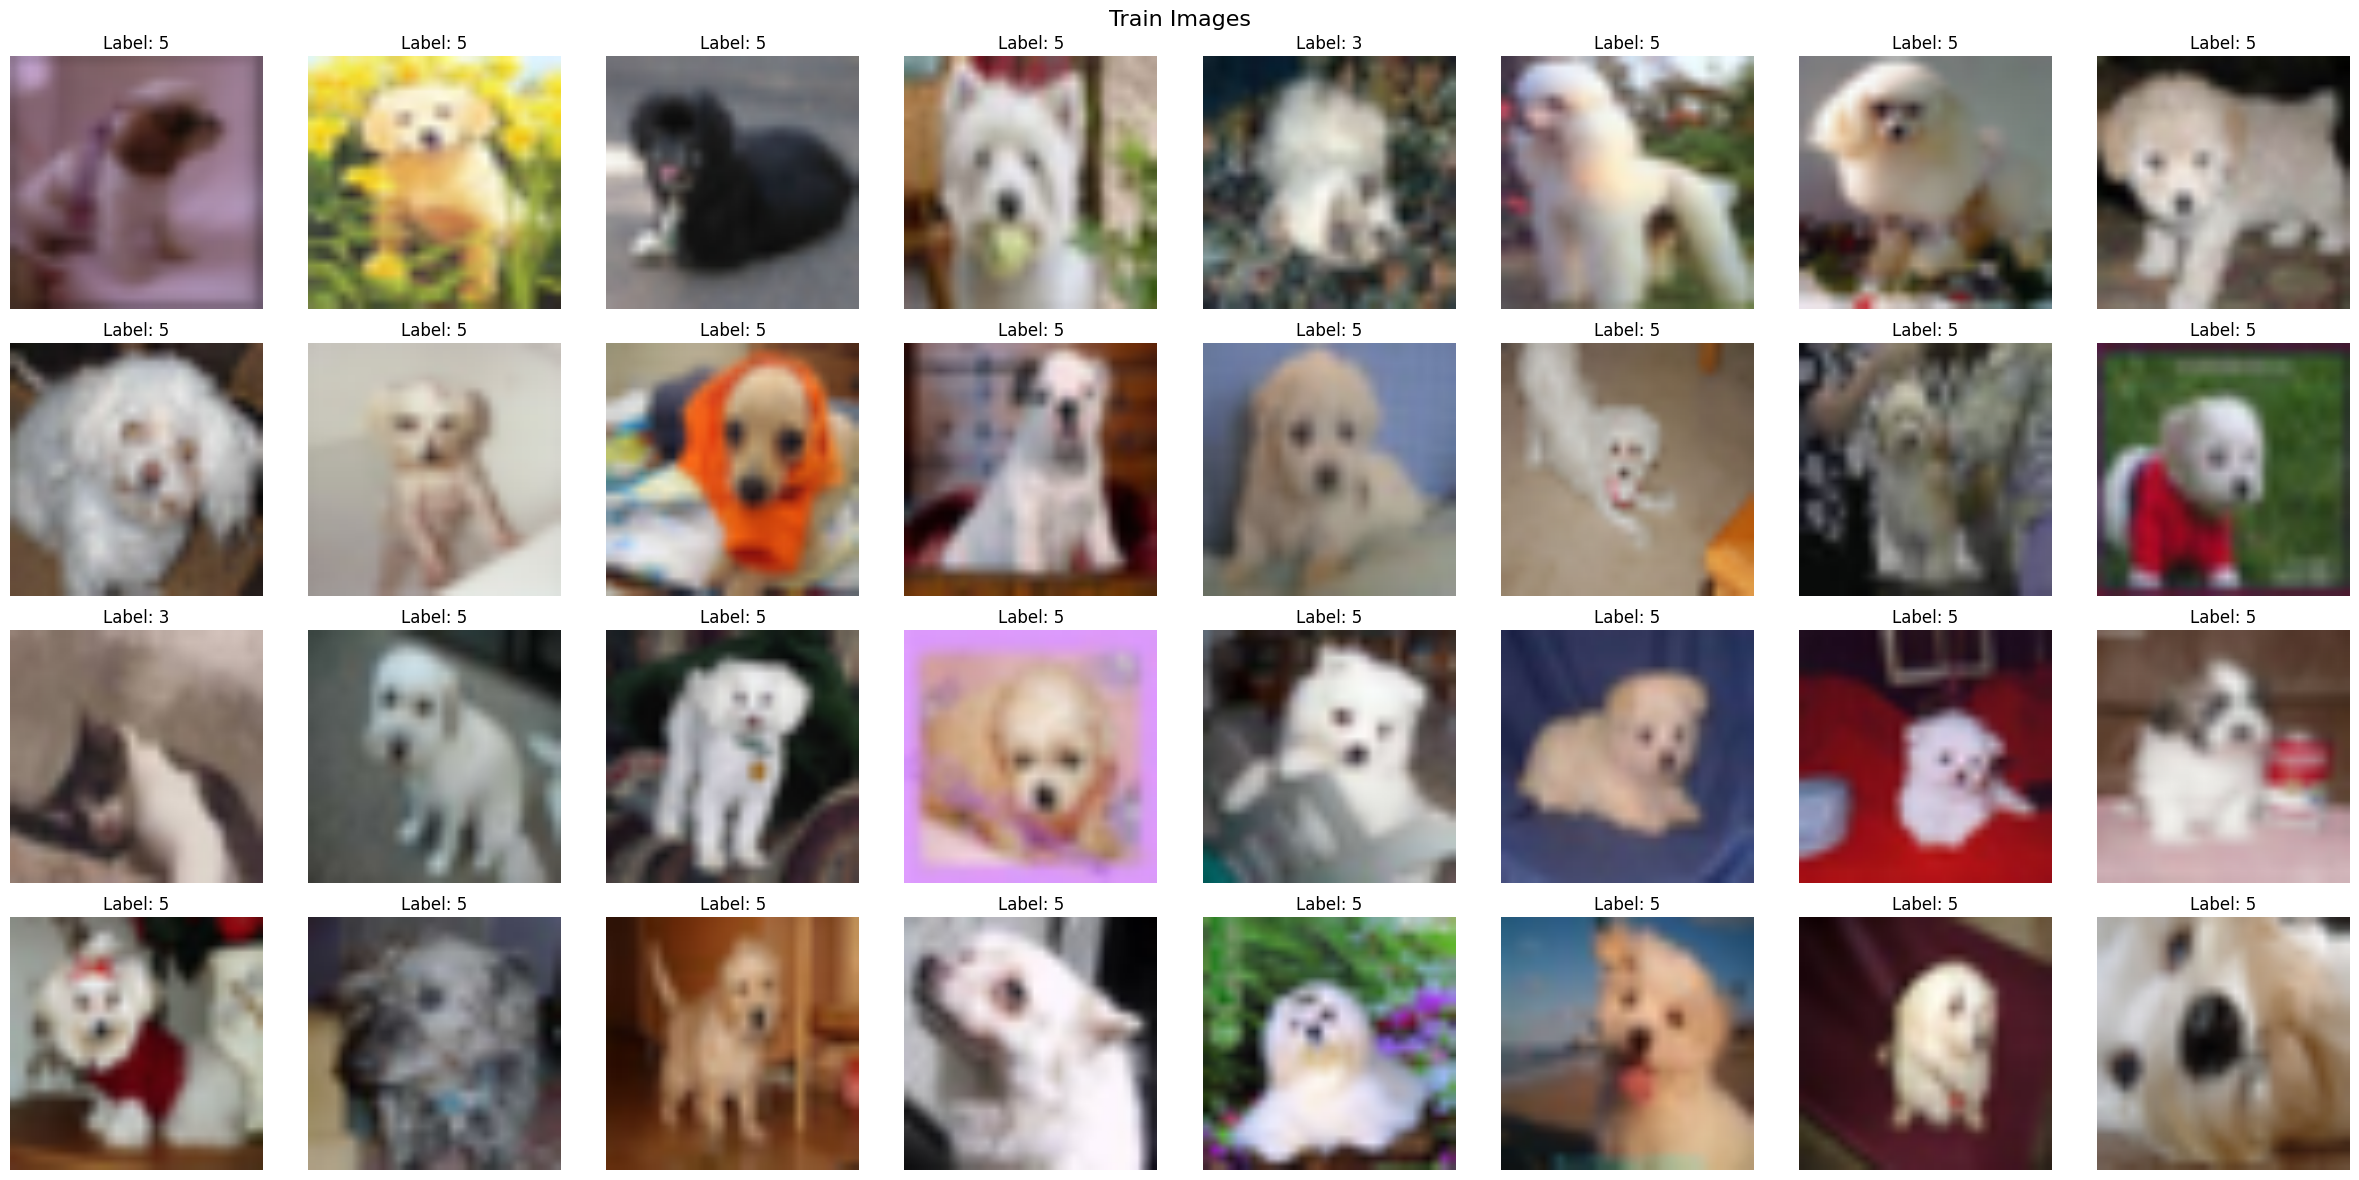

In [41]:
import matplotlib.pyplot as plt
import torch
import random
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert PIL images to tensors
])

# Function to display images in a grid
def show_images_grid(images, labels, rows=3, cols=4, title=None):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if title:
        fig.suptitle(title, fontsize=16)
    
    # Flatten axes if it’s a 2D array; otherwise, wrap it in a list for consistency
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (img, lbl) in enumerate(zip(images, labels)):
        if idx >= rows * cols:
            break
        ax = axes[idx]
        ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC for display
        ax.set_title(f'Label: {lbl}')
        ax.axis('off')
    
    # Turn off any extra axes
    for ax in axes[len(images):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
random_choices = random.sample(range(0, len(cluster_dict)), 2)

# Get a batch of original images and labels
for c,(i, j) in enumerate(cluster_dict.items()):
    if c in random_choices:
        print("Samples from cluster: ",c)
        # Get the train images and labels for the current test image
        train_images = [transform(ds_feature['test'][k]['img']) for k in j]
        train_labels = [ds_feature['test'][k]['label'] for k in j]
        
        # Display the train images in a grid
        show_images_grid(train_images, train_labels, rows=4, cols=8, title='Train Images')
    
